<a href="https://colab.research.google.com/github/hws2002/Time_Series_Forecasting_in_Python/blob/main/Chapter6/Chapter6_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/bandwidth.csv')
df

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816
...,...
9995,740.546059
9996,738.906228
9997,736.057995
9998,733.559640


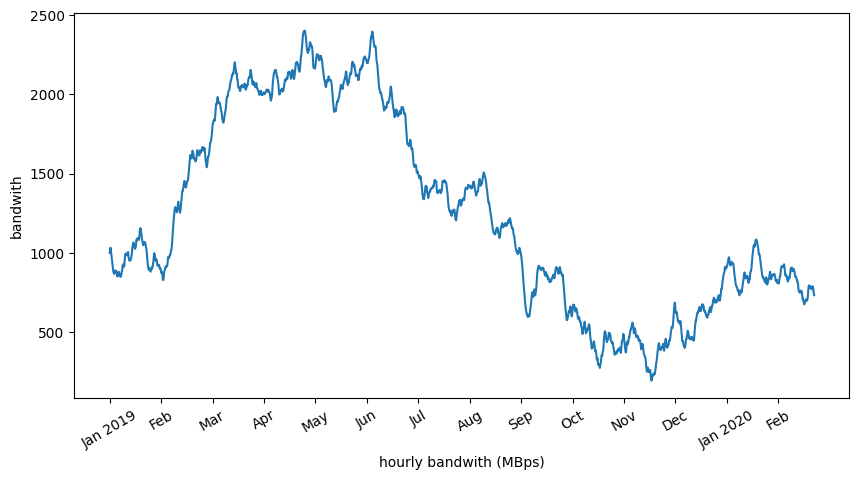

In [52]:
fig,ax = plt.subplots(figsize=(10,5))

plt.plot(df)
ax.set_xlabel('hourly bandwith (MBps)')
ax.set_ylabel('bandwith')
plt.xticks(np.arange(0,10000,730),
           ['Jan 2019', 'Feb' ,'Mar' ,'Apr' ,'May' ,'Jun', 'Jul', 'Aug' ,'Sep', 'Oct', 'Nov' ,'Dec', 'Jan 2020', 'Feb'])
plt.xticks(rotation=30)
plt.show()

시간에 따른 장기적인 추세를 확인했을떄, 이 수열이 정상적이 아닐 가능성이 높으므로 변환을 적용해야 한다. 또한 주기적인 형태가 없는 것으로 보이므로 계절성이 존재할 가능성을 배재할 수 있다.

ADF테스트를 통해 확인해보자

In [53]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df['hourly_bandwidth'])
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -0.8714653199452735
p-value :  0.7972240255014551


p-value가 0.05보다 크므로, 귀무가설이 채택되어 수열은 비정상적이라고 볼 수 있다.  


차분을 통해 수열을 정상적으로 만들어보자

In [54]:
df_diff = np.diff(df['hourly_bandwidth'],n=1)
print(df_diff.shape)

(9999,)


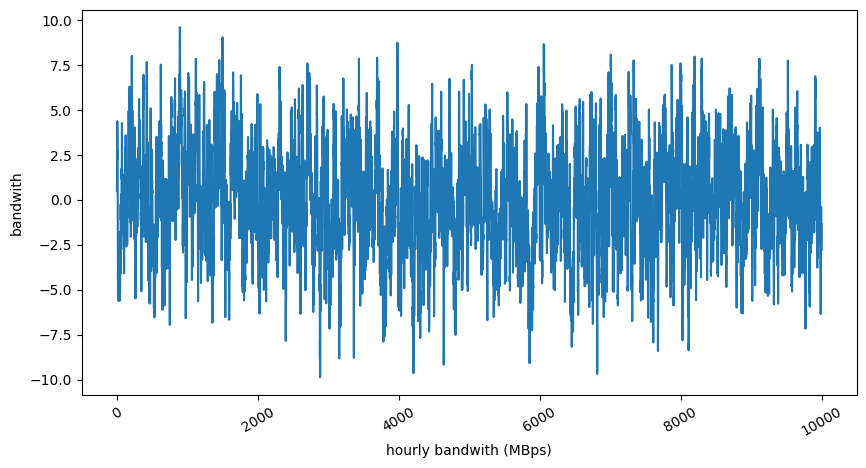

In [55]:
fig,ax = plt.subplots(figsize=(10,5))

plt.plot(df_diff)
ax.set_xlabel('hourly bandwith (MBps)')
ax.set_ylabel('bandwith')
plt.xticks()
plt.xticks(rotation=30)
plt.show()

도식화하여 살펴보았을때, 정상성을 가진것으로 보인다.  
ADF검정을 해보자

In [56]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df_diff)
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -20.694853863789017
p-value :  0.0


귀무가설이 기각되어 수열이 정상적임을 알 수 있다.  
차례로 ACF 함수를 도식화해보자

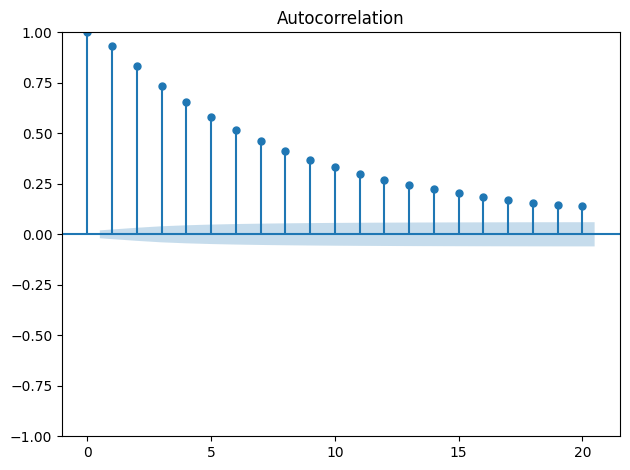

In [57]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_diff, lags= 20)
plt.tight_layout()

지연 0 이후에 유의한 자기상관계수가 존재하여 확률보행은 아니다.  
허나 계수가 서서히 감소하기만 할 뿐 특정 지연을 지나 갑자기 유의하게 되지는 않으므로, 순수한 이동평균과정이 아님을 뜻한다.

그렇다면 PACF 함수를 도식화해보자

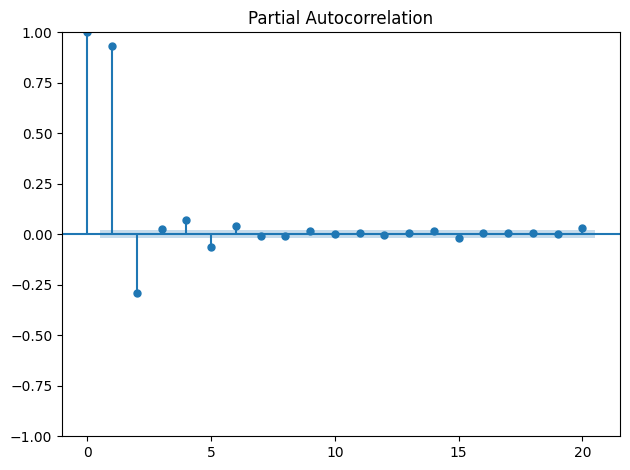

In [58]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_diff, lags=20)
plt.tight_layout()

이번에는 사인곡선 패턴을 확인할 수 있는데, 이는 '특정 지연 후 계수가 유의하지 않게 되는 현상'을 확인할 수 없다는 것을 뜻한다.  
이에 따라 순수한 자기회귀과정이 아니라는 결론을 내릴 수 있다.

# 일반적 모델링 절차

## AIC 사용하여 모델 선택하기

In [59]:
from itertools import product

ps = range(0,4,1)
qs = range(0,4,1)

order_list = list(product(ps,qs))

order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [60]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog : Union[pd.Series, list], order_list : list) -> pd.DataFrame :
  results = []

  for order in tqdm_notebook(order_list):
    try :
      model = SARIMAX(endog, order = (order[0], 0, order[1]),
                      simple_differencing=False).fit(disp = False)
    except:
      continue

    aic = model.aic
    results.append([order, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['order', 'aic']
  result_df = result_df.sort_values(by = 'aic', ascending =  True).reset_index(drop = True)

  return result_df

In [61]:
result_df = optimize_ARMA(df_diff, order_list)
result_df

<ipython-input-60-b157b1d9a992>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,order,aic
0,"(3, 2)",28451.239020
1,"(2, 3)",28451.415534
2,"(2, 2)",28451.715630
3,"(3, 3)",28453.442374
4,"(1, 3)",28462.681589
5,"(1, 2)",28511.683945
6,"(3, 1)",28534.528098
7,"(3, 0)",28557.696231
8,"(2, 1)",28559.689002
9,"(2, 0)",28561.484563


처음 세 모델의 AIC가 모두 28451이며, 약간의 차이만 있음을 알 수 있다.  
이 중 (2,2)모델은 덜 복잡하면서도 AIC값은 ARMA(3,2), ARMA(2,3)모델과 거의 같기 때문에 ARMA(2,2) 모델을 선택하겠다.  

수열을 훈련 집합과 테스트 집합으로 분할하겠다.  
테스트 집합에 지난 7일간의 데이터(총 168시간)을 포함하겠다.  

In [94]:
df_diff = np.diff(df['hourly_bandwidth'],n=1)
df_diff = pd.DataFrame({'bandwidth_diff' : df_diff})
# df_diff.index = np.arange(1,10000)

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


차분된 수열과 원본 수열 모두에 대한 훈련 집합과 테스트 집합을 시각화해보자.

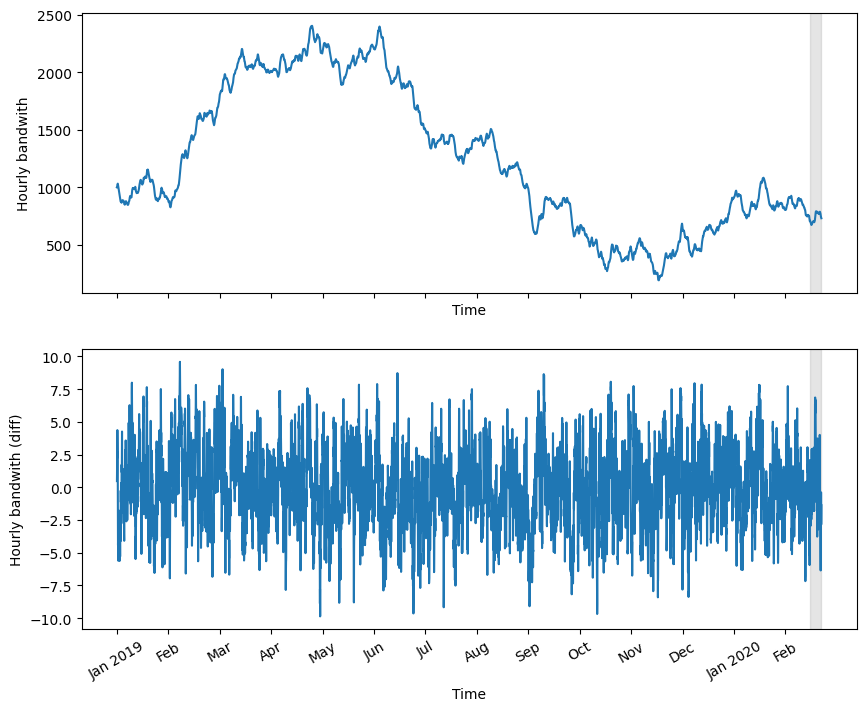

In [95]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex=  True, figsize = (10,8))

ax1.plot(df)
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwith')
ax1.axvspan(9831, 10000, color = '#808080', alpha = 0.2)

ax2.plot(np.arange(1,10000), df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwith (diff)')
ax2.axvspan(9831, 10000, color = '#808080', alpha = 0.2)
plt.xticks(np.arange(0,10000,730),
           ['Jan 2019', 'Feb' ,'Mar' ,'Apr' ,'May' ,'Jun', 'Jul', 'Aug' ,'Sep', 'Oct', 'Nov' ,'Dec', 'Jan 2020', 'Feb'])
plt.xticks(rotation=30)
plt.show()

잔차 분석을 수행하기 위해 ARMA(2,2)모델을 훈련 집합에 피팅하고, plot_diagnostics 메서드를 사용하여 Q-Q도식과 다른 도식들을 확인해보자.

In [81]:
train.index = np.arange(0, len(train))

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Thu, 12 Dec 2024   AIC                          27991.604
Time:                        04:48:01   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

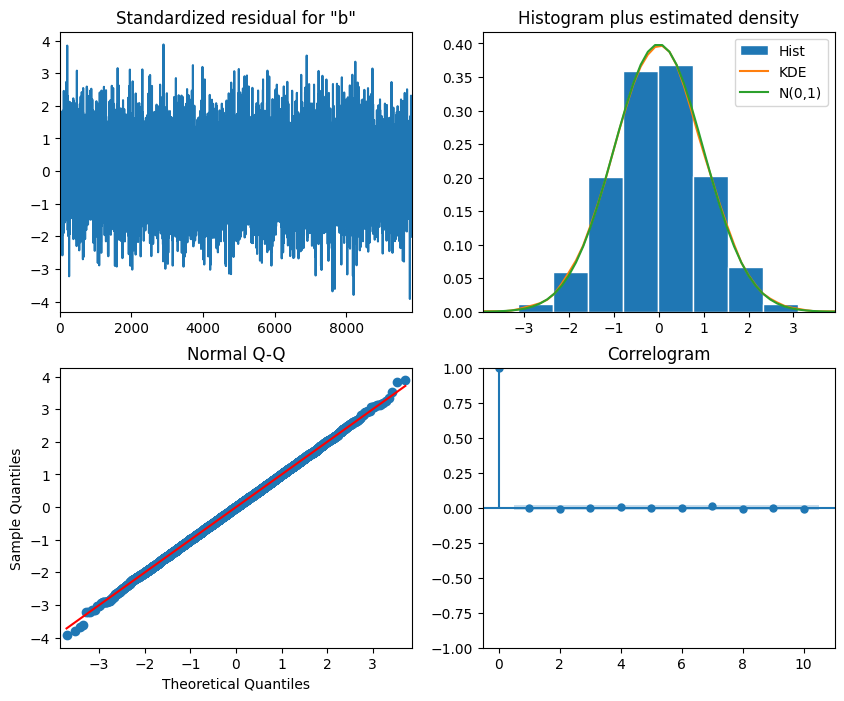

In [82]:
model = SARIMAX(train['bandwidth_diff'], order = (2,0,2), simple_differencing = False)
model_fit = model.fit(disp = False)
print(model_fit.summary())

model_fit.plot_diagnostics(figsize = (10,8));

왼쪽 상단 도식에서 어떤 추세를 확인할 수 없고, 평균 시간이 흘러도 일정하므로 잔차가 정상적일 가능성이 높다는 것을 알 수 있다.  
오른쪽 위는 정규분포와 유사한 모양의 밀도를 확인할 수 있다.  
왼쪽 하단의 Q-Q도식은 y=x직선과 거의 같은 굵은 직선을 보여준다.  
마지막으로 오른쪽 하단의 ACF 도식은 지연 0이후 자기상관관계가 없음을 보여준다.  

따라서 잔차가 정규분포를 보이고 상관관계도 없으므로 백색소음과 매우 유사하다는 점을 나타낸다.


처음 10개의 지연에 대한 잔차에 대해 융-박스 테스트를 실행해보자.

In [88]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1,11,1))
print(tr)

     lb_stat  lb_pvalue
1   0.042190   0.837257
2   0.418364   0.811247
3   0.520271   0.914416
4   0.850554   0.931545
5   0.850841   0.973678
6   1.111754   0.981019
7   2.124864   0.952607
8   3.230558   0.919067
9   3.248662   0.953615
10  3.588289   0.964015


반환된 p값은 모두 0.05를 초과했다. 따라서 잔차에 실제로 상관관계가 없다는 결론을 내릴 수 있다.  

ARMA(2,2)모델은 잔차 분석에 대한 모든 검사를 통과했으므로, 이제 이 모델을 사용하여 대역폭 사용량을 예측해보자.  



# 대역폭 사용량 예측하기

ARMA(2,2) 모델을 사용하여 7일의 기간에 대해 다음 2시간 동안의 대역폭 사용량을 예측해보자.

In [97]:
def rolling_forecast(df : pd.DataFrame, train_len :int, horizon : int, window : int, method : str) -> list:
  total_len = train_len + horizon
  end_idx = train_len

  if method == 'mean':
      pred_mean = []
      for i in range(train_len, total_len, window):
        mean = np.mean(df[:i].values)
        pred_mean.extend(mean for _ in range(window))
      return pred_mean
  elif method == 'last':
    pred_last = []
    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last.extend(last_value for _ in range(window))
    return pred_last
  elif method == 'ARMA':
    pred_ARMA = []
    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order = (2,0,2))
      res = model.fit(disp = False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_ARMA.extend(oos_pred)
    return pred_ARMA


In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:,'pred_mean'] = pred_mean
test.loc[:,'pred_last'] = pred_last
test.loc[:,'pred_ARMA'] = pred_ARMA
test

In [143]:
test.to_csv('test.csv',index = True)

다음으로 각 방법의 예측결과를 도식화하여 시각화한다.

[]

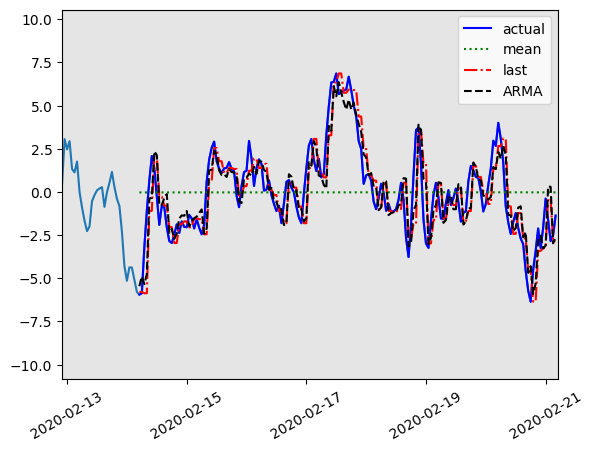

In [145]:
fig, ax = plt.subplots()

plt.plot(df_diff)
plt.plot(test.iloc[:,-4], 'b-', label ='actual')
plt.plot(test.iloc[:,-3], 'g:', label ='mean')
plt.plot(test.iloc[:,-2], 'r-.', label ='last')
plt.plot(test.iloc[:,-1], 'k--', label ='ARMA')
ax.set_xlim(9800, 9999)

ax.axvspan(9800, 9999, color = '#808080', alpha = 0.2)
plt.xticks(
   [9802, 9850, 9898, 9946, 9994],
   ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19' ,'2020-02-21']
)
plt.xticks(rotation = 30)
plt.legend()
plt.plot()

이제 각 모델의 성능을 MSE로 평가해보자

In [146]:
from sklearn.metrics import mean_squared_error
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.7690462114420604


ARMA(2,2) 모델의 mse값인 1.7690... 이 제일 낮은것을 확인할 수 있다.  


# 역변환

누적 합계를 적용하여 역변환을 진행한다.

In [147]:
np.arange(9832,1000,1)


array([], dtype=int64)

In [148]:
pred_arma = test['pred_ARMA']
pred_arma.index = np.arange(9832,10000)
pred_arma.cumsum()

,pred_ARMA
9832,-5.460661
9833,-10.351288
9834,-15.687193
9835,-20.438923
9836,-20.814520
...,...
9995,4.200170
9996,4.525521
9997,4.819809
9998,1.843959


In [149]:
df['pred_bandwidth'] = pd.Series()
df.loc[9832:,'pred_bandwidth'] = df.loc[9831,'hourly_bandwidth'] + pred_arma.cumsum()
df[9831:]

,hourly_bandwidth,pred_bandwidth
9831,723.120934,NaN
9832,717.176939,717.660272
9833,711.311745,712.769646
9834,708.114679,707.433741
9835,707.024482,702.68201
...,...,...
9995,740.546059,727.321104
9996,738.906228,727.646455
9997,736.057995,727.940743
9998,733.559640,724.964893


[]

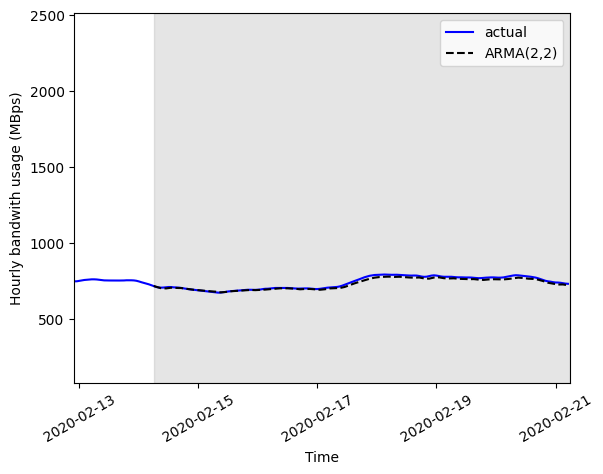

In [150]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'], 'b-', label = 'actual')
ax.plot(df['pred_bandwidth'], 'k--', label = 'ARMA(2,2)')
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9832, 10000, color  = '#808080', alpha = 0.2)
ax.set_xlim(9800, 10000)
plt.xticks(
   [9802, 9850, 9898, 9946, 9994],
   ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19' ,'2020-02-21']
)
plt.xticks(rotation = 30)
plt.legend()
plt.plot()

역차분된 ARMA(2,2)예측값의 평균절대오차를 측정하여 예측이 실젯값과 얼마나 차이가 나는지를 파악해보자.

In [151]:
from sklearn.metrics import mean_absolute_error
mea_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])
print(mea_ARMA_undiff)

8.412254083433078


평균적으로 예측갑싱 실제 대역폭 사용량보다 14Mbps정도 높거나 낮다는 것을 뜻한다.